In [140]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [141]:
print("Loading data...")
df = pd.read_csv('/Users/vipulpandey/DS-Intern-Assignment/data/data.csv')


Loading data...


In [142]:
df.shape

(16857, 29)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  float64
 13  z

In [144]:
df.head()

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  float64
 13  z

In [146]:
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)


In [147]:
df.rename(columns=lambda x: x.strip(), inplace=True)
for col in df.select_dtypes(include="object").columns:
    df[col] = pd.to_numeric(df[col].str.strip(), errors="coerce")
corr_with_target = df.corr(numeric_only=True)["equipment_energy_consumption"]

print(corr_with_target)



equipment_energy_consumption    1.000000
lighting_energy                 0.057007
zone1_temperature               0.018402
zone1_humidity                  0.026997
zone2_temperature               0.042058
zone2_humidity                 -0.003984
zone3_temperature               0.038033
zone3_humidity                  0.006724
zone4_temperature               0.017128
zone4_humidity                 -0.003232
zone5_temperature               0.008938
zone5_humidity                  0.007903
zone6_temperature               0.032136
zone6_humidity                 -0.019381
zone7_temperature               0.007255
zone7_humidity                 -0.006884
zone8_temperature               0.019716
zone8_humidity                 -0.023995
zone9_temperature               0.003985
zone9_humidity                 -0.022693
outdoor_temperature             0.033223
atmospheric_pressure           -0.014060
outdoor_humidity               -0.039493
wind_speed                      0.011566
visibility_index

In [148]:
df.drop(columns=['visibility_index','random_variable1','random_variable2'], inplace=True)

In [149]:
print("\nPerforming Time Series Analysis...")
print("Dataset Shape:", df.shape)
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())



Performing Time Series Analysis...
Dataset Shape: (16857, 25)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16857 entries, 2016-01-11 17:00:00 to 2016-12-01 15:50:00
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   equipment_energy_consumption  15945 non-null  float64
 1   lighting_energy               15993 non-null  float64
 2   zone1_temperature             15908 non-null  float64
 3   zone1_humidity                15969 non-null  float64
 4   zone2_temperature             15934 non-null  float64
 5   zone2_humidity                15990 non-null  float64
 6   zone3_temperature             16055 non-null  float64
 7   zone3_humidity                15979 non-null  float64
 8   zone4_temperature             16041 non-null  float64
 9   zone4_humidity                16076 non-null  float64
 10  zone5_temperature             16019 non-null  float64
 11  zone5_h

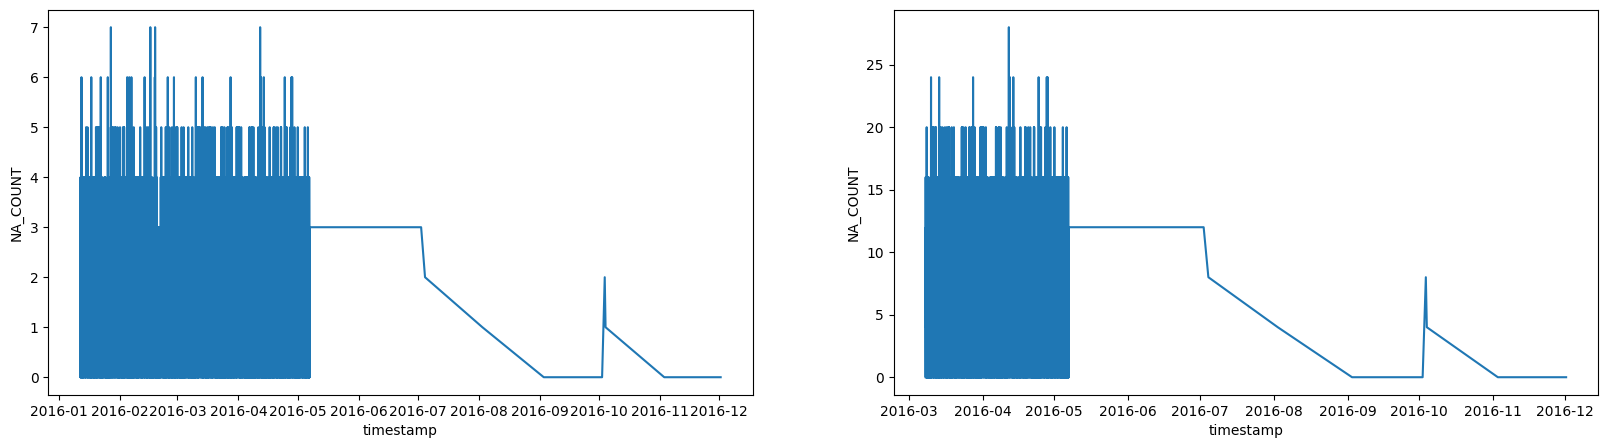

In [158]:
nan_by_date=df.isna().sum(axis=1)
nan_by_date=nan_by_date.rename('NA_COUNT').reset_index()
perc_nan_by_date=nan_by_date.copy()
perc_nan_by_date.NA_COUNT=100*perc_nan_by_date.NA_COUNT/25
fig,ax=plt.subplots(ncols=2,figsize=(20,5))
sns.lineplot(nan_by_date,x='timestamp',y='NA_COUNT',ax=ax[0])
sns.lineplot(perc_nan_by_date[-8700:],x='timestamp',y='NA_COUNT',ax=ax[1])
ax[1].set_label('% device down')

In [159]:
perc_nan_by_date

,timestamp,NA_COUNT
0,2016-01-11 17:00:00,8.0
1,2016-01-11 17:10:00,4.0
2,2016-01-11 17:20:00,4.0
3,2016-01-11 17:30:00,4.0
4,2016-01-11 17:40:00,0.0
...,...,...
16852,2016-10-03 20:10:00,8.0
16853,2016-10-04 06:10:00,4.0
16854,2016-11-03 00:50:00,0.0
16855,2016-11-04 13:20:00,0.0


In [157]:
df.shape

(16857, 25)

<Axes: >

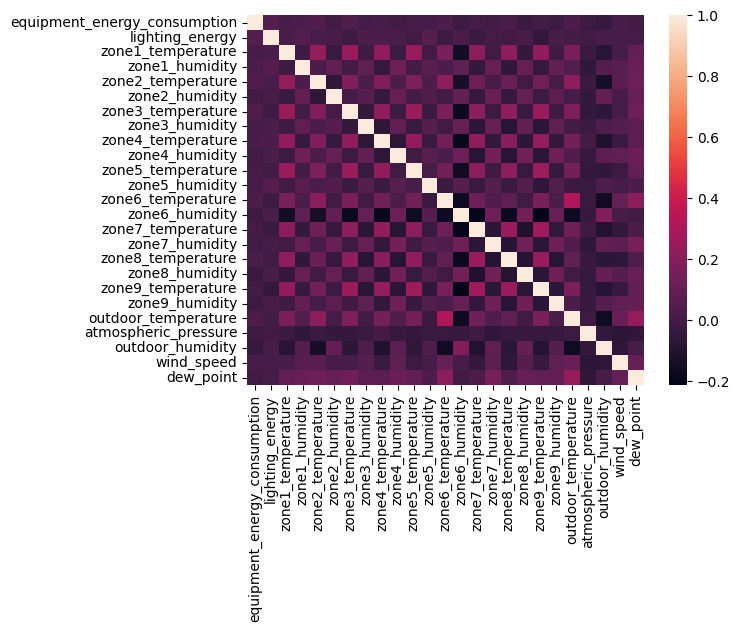

In [160]:
corr_mat=df.corr()
sns.heatmap(corr_mat)

<Axes: >

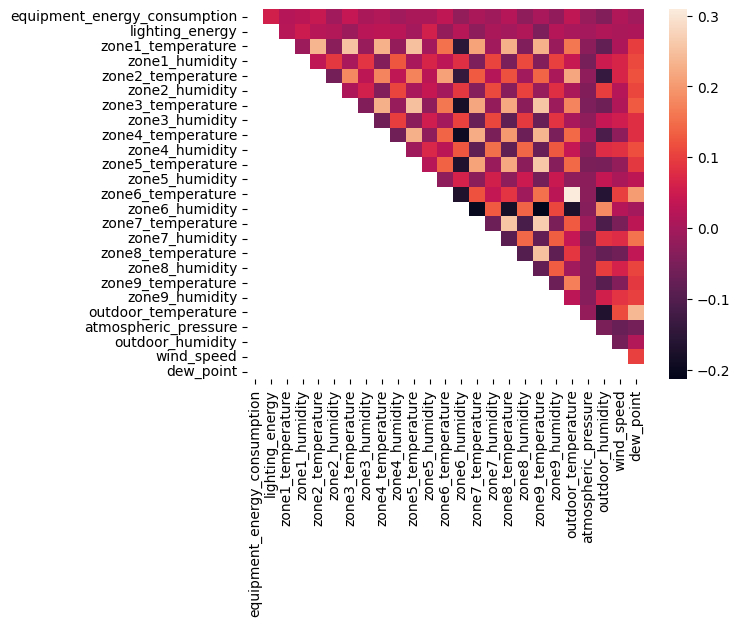

In [163]:
il=np.tril_indices(25)
tian_corr = corr_mat.copy().to_numpy()
tian_corr[il]=np.nan
tian_corr=pd.DataFrame(tian_corr,columns=corr_mat.columns,index=corr_mat.index)
sns.heatmap(tian_corr)

In [155]:
df.describe()

,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,...,zone7_humidity,zone8_temperature,zone8_humidity,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,dew_point
count,15945.000000,15993.000000,15908.000000,15969.000000,15934.000000,15990.000000,16055.000000,15979.000000,16041.000000,16076.000000,...,16052.000000,16009.000000,16080.000000,16084.000000,15969.000000,16051.000000,16015.000000,16058.000000,16029.000000,16031.000000
mean,95.810413,3.938101,21.249414,39.046066,19.793113,39.494553,21.665733,38.201314,20.239922,37.945608,...,34.032621,21.606344,41.853532,18.851085,40.318199,6.218582,755.757602,78.977595,4.195988,2.783507
std,182.753554,14.580575,2.165618,9.952521,2.943771,10.129513,2.594309,10.144388,2.783050,10.769813,...,11.345440,2.974989,12.301530,2.528783,11.168678,7.554684,13.643585,28.565660,4.409729,6.094732
min,-1139.985693,-86.002966,8.726818,-46.660000,2.988199,-77.265503,6.543921,-71.406273,4.613485,-81.446225,...,-84.882898,4.502372,-94.385668,4.476511,-81.582494,-37.524768,678.159940,-221.668765,-20.929527,-32.098095
25%,50.000000,0.000000,20.500000,37.026667,18.600000,37.757500,20.533333,36.592500,19.266667,35.200000,...,31.000000,20.500000,38.626667,17.890000,38.230000,3.000000,750.800000,71.000000,2.000000,0.450000
50%,60.000000,0.000000,21.323333,39.226667,19.600000,40.293333,21.767500,38.400000,20.290000,38.090000,...,34.230000,21.790000,42.040455,18.890000,40.363333,6.000000,756.200000,84.166667,4.000000,2.750000
75%,100.000000,0.000000,22.100000,42.500000,20.790000,43.000000,22.760000,41.433333,21.356667,41.560833,...,38.156667,22.790000,46.003889,20.200000,43.790000,9.250000,762.100000,91.988095,6.000000,5.308333
max,1139.985693,86.002966,33.746609,76.292756,36.552882,77.265503,36.823982,71.406273,35.921144,81.446225,...,84.882898,38.626835,94.385668,33.238012,81.582494,49.853906,833.392675,221.668765,29.318719,37.673716


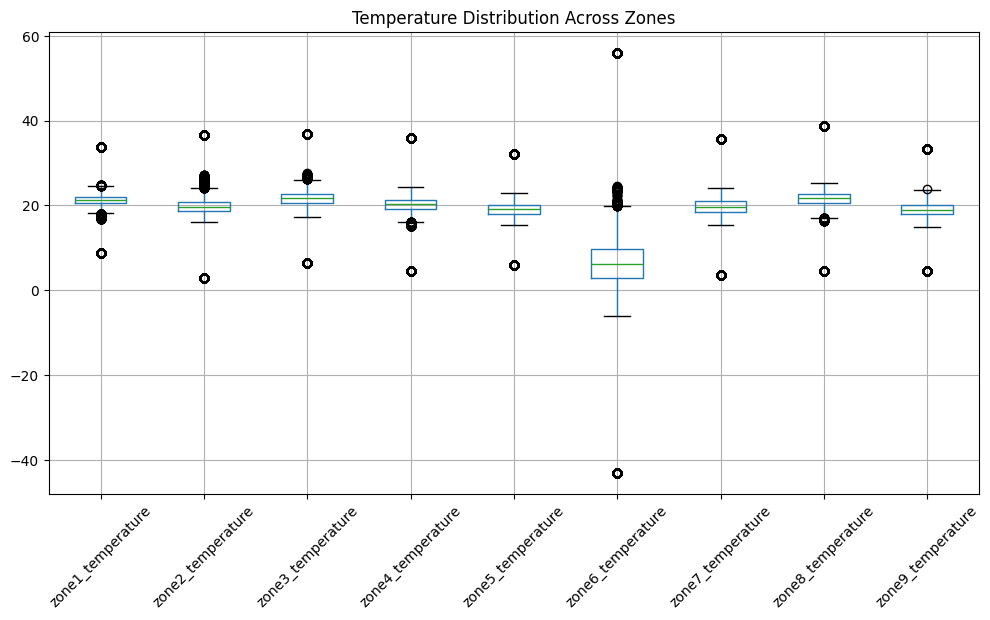

In [127]:
zone_temp_cols = [f'zone{i}_temperature' for i in range(1, 10)]
plt.figure(figsize=(12, 6))
df[zone_temp_cols].boxplot()
plt.title('Temperature Distribution Across Zones')
plt.xticks(rotation=45)
plt.show()

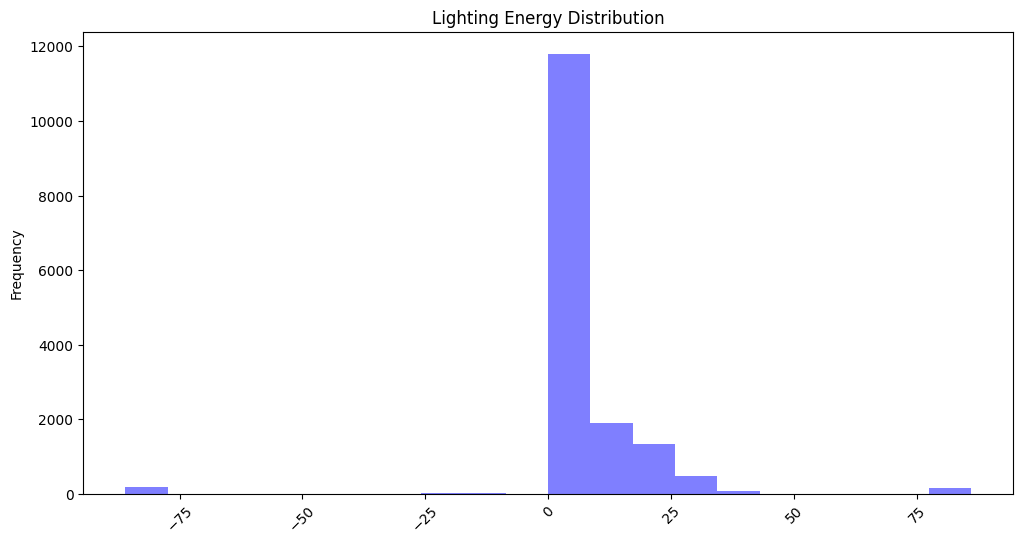

In [128]:
plt.figure(figsize=(12, 6))
df['lighting_energy'].plot(kind='hist', bins=20, alpha=0.5, color='blue', label='Lighting Energy')
plt.title('Lighting Energy Distribution')
plt.xticks(rotation=45)
plt.show()

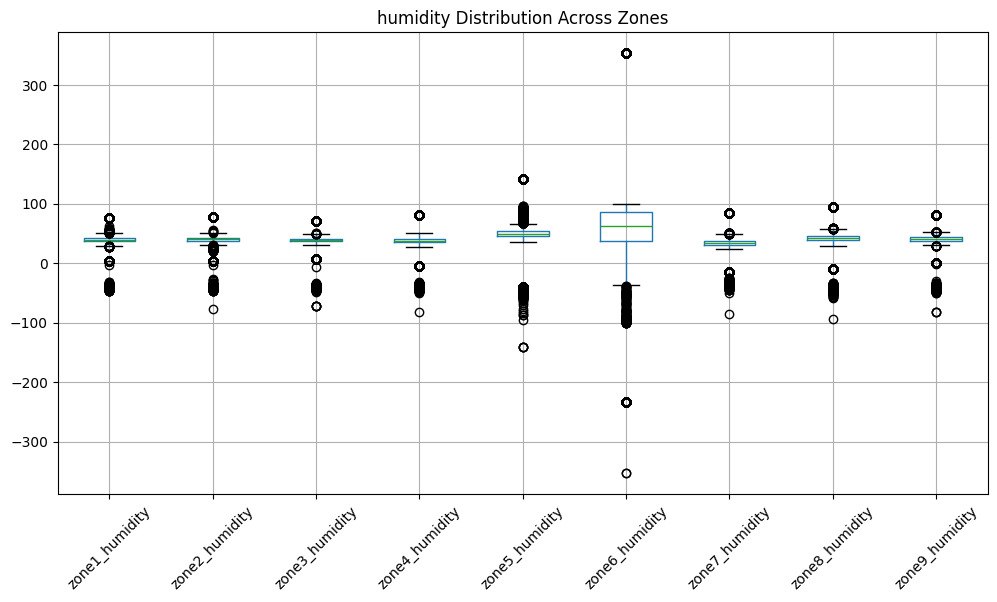

In [129]:
zone_temp_cols = [f'zone{i}_humidity' for i in range(1, 10)]
plt.figure(figsize=(12, 6))
df[zone_temp_cols].boxplot()
plt.title('humidity Distribution Across Zones')
plt.xticks(rotation=45)
plt.show()

In [130]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [131]:
df = df[df['equipment_energy_consumption'] >= 0]
df = df[df['lighting_energy'] >= 0]

In [132]:
target_col = 'equipment_energy_consumption'

# Lag features
for lag in [1, 2, 3, 6, 12, 24]:
    df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

# Rolling window features
for window in [3, 6, 12, 24]:
    df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
    df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
    df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
    df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window).max()

# Exponential weighted mean features
for span in [3, 6, 12, 24]:
    df[f'{target_col}_ewm_{span}'] = df[target_col].ewm(span=span).mean()


In [133]:
df.fillna(df.median(), inplace=True)


In [134]:
X = df.drop(target_col, axis=1)
y = df[target_col]


In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()

rmse_scores, mae_scores, r2_scores, train_r2_scores = [], [], [], []

print("\nPerforming Time Series Cross-Validation with RandomForestRegressor...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    train_r2_scores.append(train_r2)
    
    print(f"\nFold {fold} Results:")
    print(f"Training R² Score: {train_r2:.4f}")
    print(f"Test R² Score: {r2:.4f}")
    print(f"R² Score Difference (Train - Test): {train_r2 - r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

print("\nAverage Metrics Across Folds:")
print(f"Average Training R²: {np.mean(train_r2_scores):.4f} ± {np.std(train_r2_scores):.4f}")
print(f"Average Test R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")



Performing Time Series Cross-Validation with RandomForestRegressor...

Fold 1 Results:
Training R² Score: 0.9702
Test R² Score: 0.8961
R² Score Difference (Train - Test): 0.0741
RMSE: 47.4532
MAE: 22.0897

Fold 2 Results:
Training R² Score: 0.9755
Test R² Score: 0.9389
R² Score Difference (Train - Test): 0.0366
RMSE: 35.2058
MAE: 16.4403

Fold 3 Results:
Training R² Score: 0.9778
Test R² Score: 0.9557
R² Score Difference (Train - Test): 0.0221
RMSE: 31.8905
MAE: 15.8715

Fold 4 Results:
Training R² Score: 0.9799
Test R² Score: 0.9549
R² Score Difference (Train - Test): 0.0250
RMSE: 32.3597
MAE: 14.6982

Fold 5 Results:
Training R² Score: 0.9800
Test R² Score: 0.9607
R² Score Difference (Train - Test): 0.0193
RMSE: 26.0668
MAE: 12.3619

Average Metrics Across Folds:
Average Training R²: 0.9767 ± 0.0036
Average Test R²: 0.9413 ± 0.0237
Average RMSE: 34.5952 ± 7.0816
Average MAE: 16.2923 ± 3.2187


In [165]:
print("\nAverage Model Performance Metrics:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f} (±{np.std(rmse_scores):.2f})")
print(f"Average MAE: {np.mean(mae_scores):.2f} (±{np.std(mae_scores):.2f})")
print(f"Average Test R²: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"Average Train R²: {np.mean(train_r2_scores):.4f} (±{np.std(train_r2_scores):.4f})")
print(f"Average R² Difference (Train - Test): {np.mean(train_r2_scores) - np.mean(r2_scores):.4f}")



Average Model Performance Metrics:
Average RMSE: 34.60 (±7.08)
Average MAE: 16.29 (±3.22)
Average Test R²: 0.9413 (±0.0237)
Average Train R²: 0.9767 (±0.0036)
Average R² Difference (Train - Test): 0.0354


In [168]:
print("\nTraining final model on all data...")
X_scaled = scaler.fit_transform(X)

final_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
)
final_model.fit(X_scaled, y)



Training final model on all data...


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)

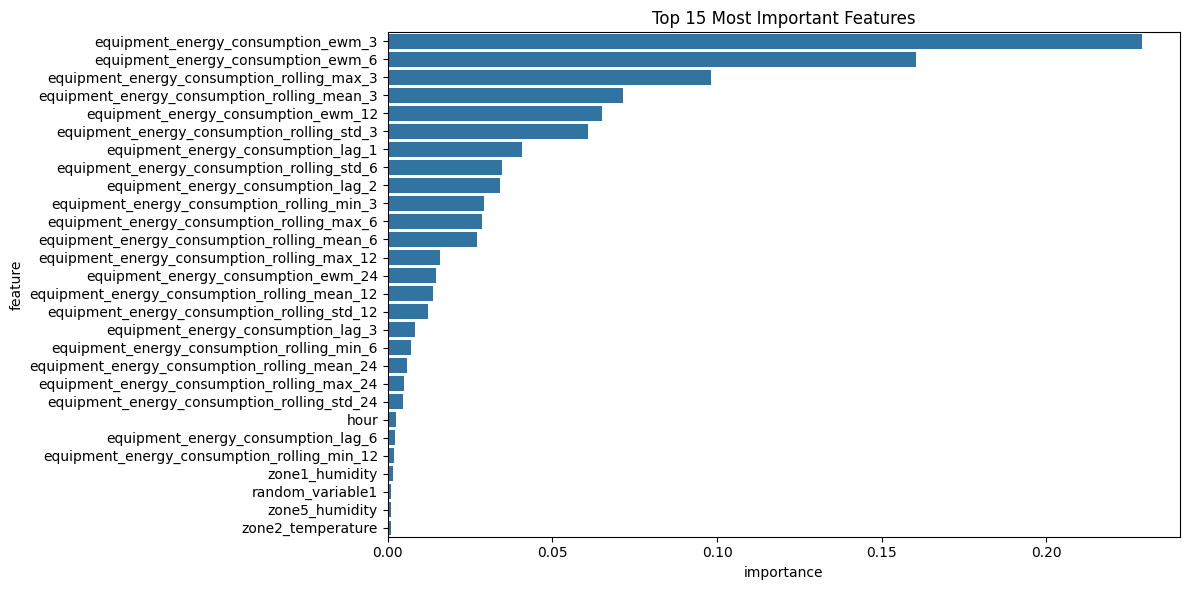

In [169]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(28))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


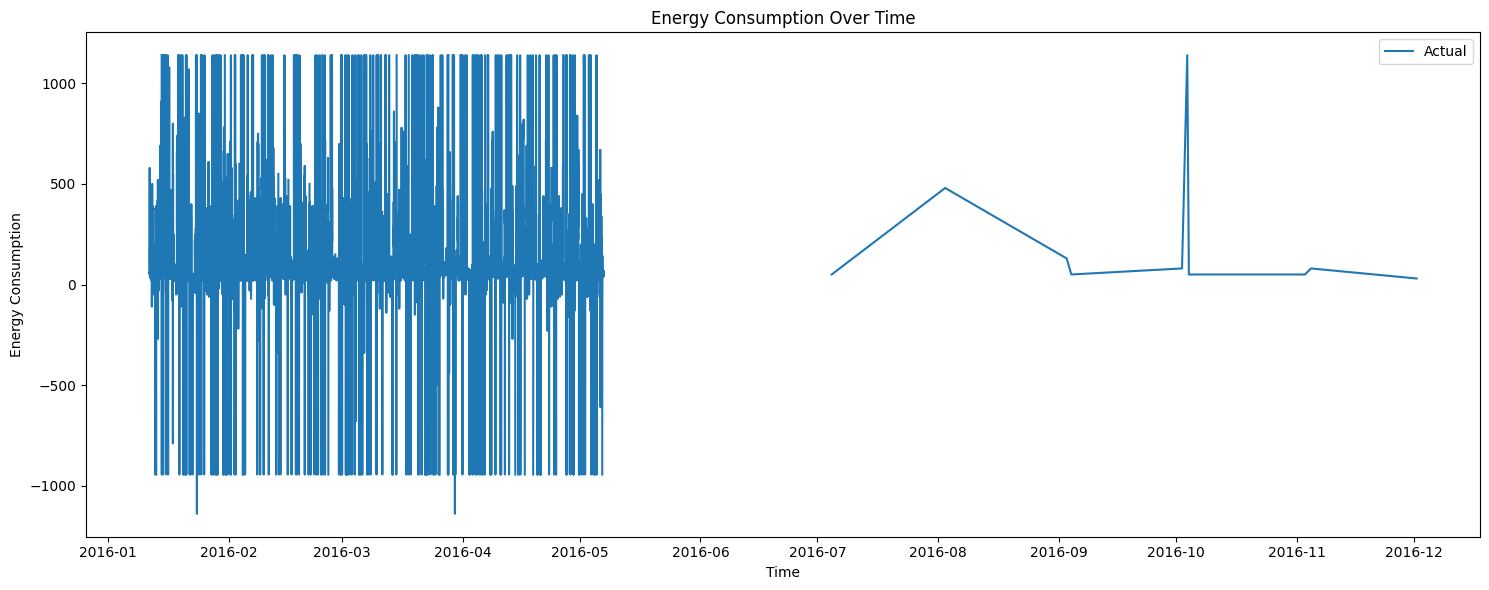

In [170]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df[target_col], label='Actual')
plt.title('Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.savefig('time_series_plot.png')
plt.show()


In [67]:
df.shape

(16857, 60)

In [68]:
df.isnull().sum()

equipment_energy_consumption                    0
lighting_energy                                 0
zone1_temperature                               0
zone1_humidity                                  0
zone2_temperature                               0
zone2_humidity                                  0
zone3_temperature                               0
zone3_humidity                                  0
zone4_temperature                               0
zone4_humidity                                  0
zone5_temperature                               0
zone5_humidity                                  0
zone6_temperature                               0
zone6_humidity                                  0
zone7_temperature                               0
zone7_humidity                                  0
zone8_temperature                               0
zone8_humidity                                  0
zone9_temperature                               0
zone9_humidity                                  0
